# NLP with TensorFlow

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f247cb75-1571-298d-973e-f1378766d8f5)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-16 09:53:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-16 09:53:05 (73.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Getting text Dataset
https://www.kaggle.com/c/nlp-getting-started/data

In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-03-16 09:53:10--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.128, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-03-16 09:53:10 (106 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df_shuffled = train_df.sample(frac=1, random_state=123)
train_df_shuffled.head()

,id,keyword,location,text,target
1971,2836,cyclone,NaN,1970 Mercury Cyclone GT Hood Moulding Very NIC...,0
2502,3593,desolate,NaN,The Desolate Hope: Part 2: MIRAD: http://t.co/...,0
5371,7663,panic,NaN,we was all just laughing and talking junk now ...,0
6258,8942,storm,NaN,FINALLY a storm,0
549,798,battle,NaN,Dragon Ball Z: Battle Of Gods (2014) - Rotten ...,0


In [8]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
len(train_df), len(test_df)

(7613, 3263)

In [9]:
import random
random_index = random.randint(0, len(train_df)-5)

for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target : {target}", "(real disater)" if target > 0 else"(not real disaster)")
  print(f"Text :\n{text}\n")
  print("----\n")

Target : 0 (not real disaster)
Text :
@joshsternberg My feed seems to have a deluge once or twice during the week. ItÛªs fantastic.

----

Target : 1 (real disater)
Text :
One man fatally shot another wounded on Vermont Street #Buffalo - http://t.co/KakY4mpCO4

----

Target : 1 (real disater)
Text :
There some flash flooding in madison #valleywx

----

Target : 0 (not real disaster)
Text :
Electricity cant stop scofield. Nigga survived a hotbox in SONA

----

Target : 0 (not real disaster)
Text :
A brave little dog gets rescued from the river.  His recovery will inspi... https://t.co/jYwFyGcLHM via @YouTube

----



### Splitting Data into training and test dataset

In [10]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size = 0.1,
                                                                            random_state=123)


In [11]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [12]:
train_sentences[:10], train_labels[:10]

(array(['@ACOUSTICMALOLEY no he was blazing it',
        "She looked back &amp; her daughter &amp; said 'everyone loved the picture I posted of you' &amp; like collided into another car like what the",
        "Couples having less sex... for fear it'll be a let down: Internet movies and books saying how sex 'ought to be' p\x89Û_ http://t.co/c1xhIzPrAd",
        'I just checked in! \x89ÛÒ at On Fire on @ZomatoAUS #LoveFood http://t.co/9l5kqykrbG',
        'This setlist from @collideworship_ this past Sunday was powerful! What song was your favorite? http://t.co/vNzyBFGZcm',
        'Strict liability in the context of an airplane accident: Pilot error is a common component of most aviation cr... http://t.co/6CZ3bOhRd4',
        'Wow what beauty lies within every storm. Taken today after a rainstorm at A&amp;B Pipeliners http://t.co/pSt5bBQ0av',
        'beforeitsnews : Global Derivatives: $1.5 Quadrillion Time Bomb http://t.co/GhmmUj7GbE (v\x89Û_ http://t.co/u9LvvLzhYe) http://t.co/LyJ57

## Text Vectorization

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [14]:
# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None,
                                 standardize="lower_and_strip_punctuation",
                                 split="whitespace",
                                 ngrams=None,
                                 output_mode="int",
                                 output_sequence_length=None)

In [15]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [16]:
text_vectorizer.adapt(train_sentences)

In [17]:
sample_text = "Plane crashed in the Arabian Sea"
text_vectorizer([sample_text])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 453,  420,    4,    2, 4173, 1050,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [18]:
random_sentence = random.choice(train_sentences)

print(f"Original sentence : \n{random_sentence}\n\
\nVectorized version : {text_vectorizer([random_sentence])}")

Original sentence : 
When your child needs emergency care they can be seen in our Emergency Department by @radychildrens Specialists! http://t.co/IGwsTTTkWK

Vectorized version : [[  44   35  755  768   73  500   63   72   22  738    4  109   73 1077
    18]]


In [19]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number f words in vocab :{len(words_in_vocab)}")
print(f"Top 5 common words : {top_5_words}")
print(f"Least 5 common words : {bottom_5_words}")

Number f words in vocab :10000
Top 5 common words : ['', '[UNK]', 'the', 'a', 'in']
Least 5 common words : ['pandemic', 'panay', 'panama', 'pams', 'pampered']


## Embedded Layer

In [20]:
tf.random.set_seed(123)
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_length,
                      name="embedding_1")
embedding

In [21]:
random_sentence = random.choice(train_sentences)
sample_embed = embedding(text_vectorizer([random_sentence]))
print(f"Original Text : \n{random_sentence}\
\n\nEmbedded Version : \n {sample_embed}")


Original Text : 
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE

Embedded Version : 
 [[[-0.01672121 -0.0449119   0.03843731 ...  0.02964565 -0.00503308
    0.04969437]
  [ 0.01961787  0.00613178 -0.0461385  ...  0.00585818 -0.02817166
    0.045355  ]
  [-0.04415513  0.04023744 -0.02684932 ...  0.04158044 -0.02974125
   -0.03638796]
  ...
  [ 0.042338    0.02078377  0.00871513 ... -0.03940127 -0.01885968
   -0.01476597]
  [-0.02583164  0.03589225 -0.03448367 ...  0.0124323  -0.04786621
    0.02978781]
  [ 0.01961787  0.00613178 -0.0461385  ...  0.00585818 -0.02817166
    0.045355  ]]]


In [22]:
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01672121, -0.0449119 ,  0.03843731, ...,  0.02964565,
         -0.00503308,  0.04969437],
        [ 0.01961787,  0.00613178, -0.0461385 , ...,  0.00585818,
         -0.02817166,  0.045355  ],
        [-0.04415513,  0.04023744, -0.02684932, ...,  0.04158044,
         -0.02974125, -0.03638796],
        ...,
        [ 0.042338  ,  0.02078377,  0.00871513, ..., -0.03940127,
         -0.01885968, -0.01476597],
        [-0.02583164,  0.03589225, -0.03448367, ...,  0.0124323 ,
         -0.04786621,  0.02978781],
        [ 0.01961787,  0.00613178, -0.0461385 , ...,  0.00585818,
         -0.02817166,  0.045355  ]]], dtype=float32)>

In [23]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-1.67212114e-02, -4.49118987e-02,  3.84373106e-02, -4.99308221e-02,
        2.66107358e-02,  3.41206528e-02,  3.85234244e-02, -3.04935575e-02,
       -3.88219841e-02,  7.20396638e-05, -1.06307119e-03, -1.20421536e-02,
       -4.27411459e-02,  3.15970667e-02, -1.43413544e-02, -4.49742675e-02,
        2.42784508e-02,  2.12422274e-02, -1.94208976e-02, -2.44285464e-02,
        4.58780788e-02,  9.18512419e-03, -3.39861400e-02,  1.75565369e-02,
        1.82559006e-02,  1.33271329e-02, -5.75946644e-03,  2.00188160e-03,
       -3.23265791e-02, -2.24252101e-02,  1.24124289e-02, -2.80887838e-02,
       -8.34680721e-03,  4.40394171e-02,  2.69249193e-02,  8.56857374e-03,
       -1.41503103e-02, -4.30902615e-02,  4.66806777e-02,  4.94178198e-02,
       -4.88441847e-02,  5.07102162e-03, -4.07824405e-02, -1.15583315e-02,
        2.26700939e-02,  4.54414748e-02,  3.06953676e-02,  3.76210697e-02,
       -1.99653264e-02,  1.23679861e-02, -8.76470655

## Modellong a Text Dataset

### Model 0 : Baseline using sklearn Naive bayes

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfid", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfid', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)

In [26]:
print(f"Baseline model accuracy : {baseline_score*100:.2f}%")

Baseline model accuracy : 78.74%


In [27]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10], val_labels[:10]

(array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0]), array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0]))

#### Evaluation function for model experiments

In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_preds):
  """
  Calculates model's accuracy, precision, recall and f1 score of a binary classification model
  Returns a dictionary of accuracy, precision, recall and f1 score
  """
  model_accuracy = accuracy_score(y_true,y_preds)

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_preds, average="weighted")
  model_results = {"accuracy":model_accuracy,
                   "precision":model_precision,
                   "recall":model_recall,
                   "f1_score":model_f1}

  return model_results

In [29]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_preds=baseline_preds)
baseline_results

{'accuracy': 0.7874015748031497,
 'precision': 0.7947502434595538,
 'recall': 0.7874015748031497,
 'f1_score': 0.7791626897023203}

### Model 1: Simple Dense Model

In [30]:
from helper_functions import create_tensorboard_callback

SAVE_DIR ="model.logs"

In [31]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
#x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [32]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [33]:
history_1 = model_1.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences,val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="simple_dense_layer")])

Saving TensorBoard log files to: model.logs/simple_dense_layer/20230316-095339
Epoch 1/5
215/215 [==============================] - 21s 75ms/step - loss: 0.6120 - accuracy: 0.6917 - val_loss: 0.5210 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4436 - accuracy: 0.8167 - val_loss: 0.4521 - val_accuracy: 0.7979
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3484 - accuracy: 0.8624 - val_loss: 0.4355 - val_accuracy: 0.7992
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2856 - accuracy: 0.8880 - val_loss: 0.4452 - val_accuracy: 0.7992
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2379 - accuracy: 0.9110 - val_loss: 0.4561 - val_accuracy: 0.7992


In [34]:
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4561 - accuracy: 0.7992


[0.45614445209503174, 0.7992125749588013]

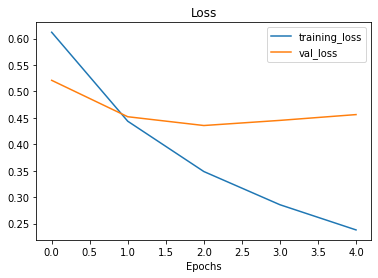

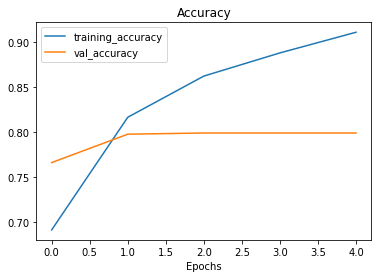

In [35]:
plot_loss_curves(history_1)

In [36]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.02222372,  0.04729468,  0.03171679, ...,  0.00470733,
         -0.0218503 , -0.01694234],
        [-0.01149023, -0.03794634,  0.03814558, ...,  0.00181252,
         -0.00103509, -0.0410762 ],
        [ 0.04716208, -0.0272762 , -0.02388137, ...,  0.01262669,
          0.00092097,  0.01559078],
        ...,
        [-0.04803668, -0.04896562, -0.08410682, ...,  0.05957755,
          0.05801915,  0.06863692],
        [ 0.1057579 ,  0.04883031,  0.01188585, ..., -0.09415936,
         -0.06818955, -0.02908814],
        [ 0.06589964,  0.01408609,  0.10465115, ..., -0.02110954,
         -0.02850109, -0.07506673]], dtype=float32)>]

In [37]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [38]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.23274659],
       [0.10113887],
       [0.7714335 ],
       [0.48168114],
       [0.18146077],
       [0.0011157 ],
       [0.66890514],
       [0.9998455 ],
       [0.19246884],
       [0.79567236]], dtype=float32)

In [39]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 0., 1., 1., 0., 1.], dtype=float32)>

In [40]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_preds=model_1_preds)
model_1_results

{'accuracy': 0.7992125984251969,
 'precision': 0.797927833200236,
 'recall': 0.7992125984251969,
 'f1_score': 0.7976760056091645}

In [41]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

### Model 2 : LSTM

In [42]:
from tensorflow.keras import layers

In [43]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)

x = layers.LSTM(64)(x)
print(x.shape)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


(None, 15, 128)
(None, 64)


In [45]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [46]:
history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences,val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                               "Model_2_LSTM")])

Saving TensorBoard log files to: model.logs/Model_2_LSTM/20230316-100832
Epoch 1/5
215/215 [==============================] - 18s 64ms/step - loss: 0.2212 - accuracy: 0.9216 - val_loss: 0.5710 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1556 - accuracy: 0.9422 - val_loss: 0.6527 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1278 - accuracy: 0.9502 - val_loss: 0.7061 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1039 - accuracy: 0.9596 - val_loss: 0.6741 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0865 - accuracy: 0.9672 - val_loss: 0.9169 - val_accuracy: 0.7730


In [47]:
model_2.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 6ms/step - loss: 0.9169 - accuracy: 0.7730


[0.9169024229049683, 0.7729659080505371]

In [50]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

24/24 [==============================] - 1s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 0., 1., 1., 1., 1.], dtype=float32)>

In [52]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_preds=model_2_preds)
model_2_results

{'accuracy': 0.7729658792650919,
 'precision': 0.7728509306781185,
 'recall': 0.7729658792650919,
 'f1_score': 0.772907053622098}

In [53]:
np.array(list(model_2_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Model 3 : GRU

In [54]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [56]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
history_3 = model_3.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences,val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                               "model_3_GRU")])

Saving TensorBoard log files to: model.logs/model_3_GRU/20230316-103116
Epoch 1/5
215/215 [==============================] - 20s 76ms/step - loss: 0.1523 - accuracy: 0.9404 - val_loss: 0.8010 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0860 - accuracy: 0.9692 - val_loss: 0.9062 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0749 - accuracy: 0.9701 - val_loss: 0.8353 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0609 - accuracy: 0.9743 - val_loss: 0.8600 - val_accuracy: 0.7388
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0551 - accuracy: 0.9765 - val_loss: 1.1226 - val_accuracy: 0.7585


In [58]:
model_3.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 1.1226 - accuracy: 0.7585


[1.1226426362991333, 0.7585301995277405]

In [59]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

24/24 [==============================] - 1s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 0., 1., 1., 1., 0.], dtype=float32)>

In [60]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_preds=model_3_preds)
model_3_results

{'accuracy': 0.7585301837270341,
 'precision': 0.7585301837270341,
 'recall': 0.7585301837270341,
 'f1_score': 0.7585301837270341}

In [63]:
np.array(list(model_3_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Model 4 : Bi-Directional RNN

In [64]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [65]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [67]:
history_4 = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model.logs/bidirectional_RNN/20230316-110631
Epoch 1/5
215/215 [==============================] - 19s 65ms/step - loss: 0.5141 - accuracy: 0.7419 - val_loss: 0.4496 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3124 - accuracy: 0.8733 - val_loss: 0.4614 - val_accuracy: 0.7913
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2042 - accuracy: 0.9240 - val_loss: 0.5733 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1412 - accuracy: 0.9510 - val_loss: 0.6123 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1031 - accuracy: 0.9637 - val_loss: 0.7829 - val_accuracy: 0.7677


In [68]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]


24/24 [==============================] - 1s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 0., 0., 1., 1., 1., 1.], dtype=float32)>

In [69]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 0.7677165354330708,
 'precision': 0.7706276954365755,
 'recall': 0.7677165354330708,
 'f1_score': 0.7686929153925879}

In [70]:
np.array(list(model_4_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Model 5 : Conv1D

In [72]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)              

In [73]:
history_5 = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model.logs/Conv1D/20230316-112734
Epoch 1/5
215/215 [==============================] - 17s 47ms/step - loss: 0.5671 - accuracy: 0.7149 - val_loss: 0.4582 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3468 - accuracy: 0.8564 - val_loss: 0.4606 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2123 - accuracy: 0.9235 - val_loss: 0.5119 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1362 - accuracy: 0.9545 - val_loss: 0.5938 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1018 - accuracy: 0.9673 - val_loss: 0.6486 - val_accuracy: 0.7835


In [74]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

24/24 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 0., 0., 0., 1., 1., 0., 1.], dtype=float32)>

In [76]:
model_5_results = calculate_results(y_true=val_labels, 
                                    y_preds=model_5_preds)
model_5_results

{'accuracy': 0.7834645669291339,
 'precision': 0.782228457706523,
 'recall': 0.7834645669291339,
 'f1_score': 0.7825346580085287}

In [77]:
np.array(list(model_5_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False,  True])

### Model 6 : Tensorflow Hub Pretrained Sentence Encoder

In [79]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder


In [80]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [81]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [82]:
history_6 = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model.logs/tf_hub_sentence_encoder/20230316-114408
Epoch 1/5
215/215 [==============================] - 11s 21ms/step - loss: 0.5101 - accuracy: 0.7787 - val_loss: 0.4162 - val_accuracy: 0.8294
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4195 - accuracy: 0.8113 - val_loss: 0.4023 - val_accuracy: 0.8320
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4051 - accuracy: 0.8219 - val_loss: 0.3977 - val_accuracy: 0.8281
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3969 - accuracy: 0.8256 - val_loss: 0.3980 - val_accuracy: 0.8215
Epoch 5/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3896 - accuracy: 0.8288 - val_loss: 0.3936 - val_accuracy: 0.8268


In [83]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

24/24 [==============================] - 1s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0.], dtype=float32)>

In [84]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 0.8267716535433071,
 'precision': 0.8274082468365386,
 'recall': 0.8267716535433071,
 'f1_score': 0.8241438433802963}

In [85]:
np.array(list(model_6_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [86]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [87]:
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [88]:
pd.Series(train_labels_10_percent).value_counts()

0    397
1    289
dtype: int64

In [89]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [90]:
history_7 = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model.logs/10_percent_tf_hub_sentence_encoder/20230316-121503
Epoch 1/5
22/22 [==============================] - 6s 46ms/step - loss: 0.6700 - accuracy: 0.6895 - val_loss: 0.6381 - val_accuracy: 0.7940
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5853 - accuracy: 0.8499 - val_loss: 0.5677 - val_accuracy: 0.8018
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4965 - accuracy: 0.8528 - val_loss: 0.5068 - val_accuracy: 0.8058
Epoch 4/5
22/22 [==============================] - 0s 23ms/step - loss: 0.4253 - accuracy: 0.8601 - val_loss: 0.4723 - val_accuracy: 0.8071
Epoch 5/5
22/22 [==============================] - 0s 22ms/step - loss: 0.3799 - accuracy: 0.8630 - val_loss: 0.4562 - val_accuracy: 0.8136


In [91]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]


24/24 [==============================] - 1s 13ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>

In [92]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 0.8136482939632546,
 'precision': 0.8126030103132285,
 'recall': 0.8136482939632546,
 'f1_score': 0.8125444821286284}

## Comparing the performance of each of our models

In [95]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1_score
baseline,0.787402,0.794750,0.787402,0.779163
simple_dense,0.799213,0.797928,0.799213,0.797676
lstm,0.772966,0.772851,0.772966,0.772907
gru,0.758530,0.758530,0.758530,0.758530
bidirectional,0.767717,0.770628,0.767717,0.768693
conv1d,0.783465,0.782228,0.783465,0.782535
tf_hub_sentence_encoder,0.826772,0.827408,0.826772,0.824144
tf_hub_10_percent_data,0.813648,0.812603,0.813648,0.812544


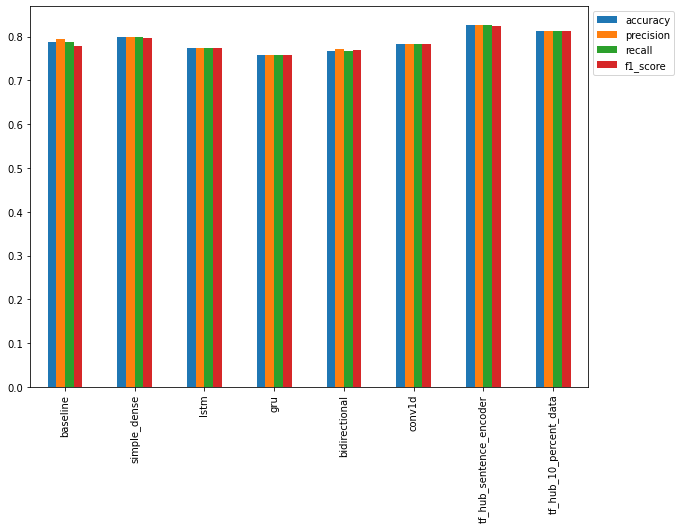

In [96]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

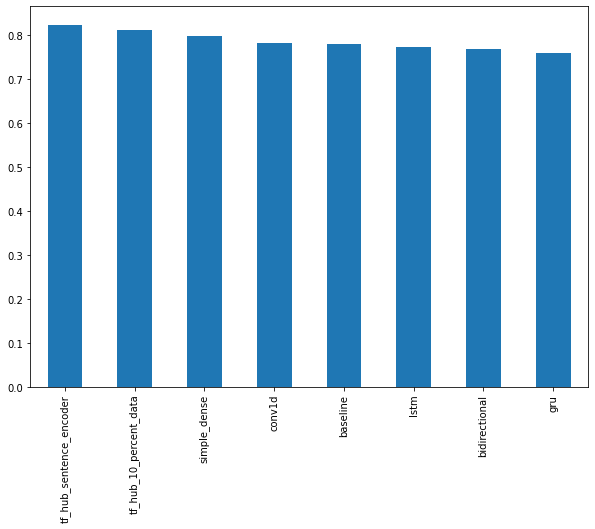

In [100]:
all_model_results.sort_values("f1_score", ascending=False)["f1_score"].plot(kind="bar", figsize=(10, 7));
